In [1]:
# basics
import pandas as pd
import numpy as np
from datetime import datetime as dt
# for graphics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
# train_test_split
from sklearn.model_selection import train_test_split
# feature scaling
from sklearn.preprocessing import StandardScaler
# algorithm
from sklearn.ensemble import RandomForestClassifier
# evaluatuon metrics
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
features = ["date","time","flow","anomaly"]
df = pd.read_csv('barreiro_ano.csv', sep=';', names=features)
holidays = pd.read_csv('holidays2018.csv',sep=';')

In [3]:
# convert column to datetime
# df['date'] = pd.to_datetime(df['date'])
# holidays['date'] = pd.to_datetime(holidays['date'])

In [4]:
# extra column indicating day of week
# 0: mon, 1:tue, ..., 5:sat, 6:sun
df['dayofweek'] = pd.to_datetime(df['date'],dayfirst=True)
df['dayofweek'] = df['dayofweek'].dt.dayofweek

In [5]:
# if day is a holiday, then dayofweek is -1
df.loc[df.date.isin(holidays.date), 'dayofweek'] = -1

-1 is definitely viable, or is the number 7 better (for example)?

In [6]:
# requisition of Feature Scaling - 1st option
# returns the day count from the date
df['date'] = pd.to_datetime(df['date'])
df['date']=df['date'].map(dt.toordinal)

In [7]:
# to extract all unique values (time) present in dataframe
time_unique_val=df.time.unique()
# in order to accept time series with different periods per day
periods_per_day=len(time_unique_val)
time_unique_ind=np.arange(periods_per_day)
#in order to have a mapping between the time of day and its index
time_unique=pd.DataFrame({'time':time_unique_val, 'time_unique_ind':time_unique_ind})
#creates a column with the time index
df['time'] = df['time'].map(time_unique.set_index('time')['time_unique_ind'])

In [8]:
df

,date,time,flow,anomaly,dayofweek
0,736695,0,18.333067,0,-1
1,736695,1,18.333067,0,-1
2,736695,2,19.784872,0,-1
3,736695,3,22.294744,0,-1
4,736695,4,27.229756,0,-1
...,...,...,...,...,...
35035,737059,91,24.792000,0,0
35036,737059,92,23.029933,0,0
35037,737059,93,20.415628,0,0
35038,737059,94,22.019056,0,0


### One-Hot Encoding

In [9]:
# One-Hot Encoding
# The first step for us is known as one-hot encoding of the data. This process takes categorical variables,
# such as days of the week and converts it to a numerical representation without an arbitrary ordering. 
# One-hot encode the data using pandas get_dummies
# features = pd.get_dummies(df)
# Display the first 5 rows of the last 12 columns
# features.head()

In [10]:
# Quando a variável day_of_week é string

### Select columns

In [11]:
# for the first test, we use all of the columns in df

### Train and test sets

In [12]:
X = df.iloc[:, [0,1,2,4]].values
y = df.iloc[:, 3].values

In [13]:
X

array([[ 7.36695000e+05,  0.00000000e+00,  1.83330667e+01,
        -1.00000000e+00],
       [ 7.36695000e+05,  1.00000000e+00,  1.83330667e+01,
        -1.00000000e+00],
       [ 7.36695000e+05,  2.00000000e+00,  1.97848722e+01,
        -1.00000000e+00],
       ...,
       [ 7.37059000e+05,  9.30000000e+01,  2.04156278e+01,
         0.00000000e+00],
       [ 7.37059000e+05,  9.40000000e+01,  2.20190556e+01,
         0.00000000e+00],
       [ 7.37059000e+05,  9.50000000e+01,  2.07920000e+01,
         0.00000000e+00]])

In [14]:
y

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [15]:
#X = df.drop(columns=['anomaly'])
#y = df['anomaly']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [17]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [18]:
classifier = RandomForestClassifier(n_estimators=550) # random_state=0
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [19]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[10489     0]
 [    5    18]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10489
           1       1.00      0.78      0.88        23

    accuracy                           1.00     10512
   macro avg       1.00      0.89      0.94     10512
weighted avg       1.00      1.00      1.00     10512

0.9995243531202436


### For Regression

In [15]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.0006659056316590563
Mean Squared Error: 0.0006659056316590563
Root Mean Squared Error: 0.025805147386888848


the error values decreases with the increase in number of estimator. After 200 the rate of decrease in error diminishes, so therefore 200 is a good number for n_estimators. You can play around with the number of trees and other parameters to see if you can get better results on your own.

In [21]:
# Make probability predictions
train_probs = classifier.predict_proba(X_train)[:, 1]
probs = classifier.predict_proba(X_test)[:, 1]

train_predictions = classifier.predict(X_train)
predictions = classifier.predict(X_test)

In [22]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

Train ROC AUC Score: 1.0
Test ROC AUC  Score: 0.9999461133195439


In [24]:
print(f'Baseline ROC AUC: {roc_auc_score(y_test, [1 for _ in range(len(y_test))])}')

Baseline ROC AUC: 0.5


Our model does outperform a baseline guess, but we can see it has severely overfit to the training data, acheiving perfect ROC AUC.

In [25]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


In [26]:
from collections import Counter
print(Counter(probs))
print(Counter(predictions))

Counter({0.0: 10102, 0.0018181818181818182: 156, 0.0036363636363636364: 55, 0.005454545454545455: 34, 0.007272727272727273: 26, 0.00909090909090909: 17, 0.012727272727272728: 17, 0.014545454545454545: 9, 0.02181818181818182: 5, 0.016363636363636365: 5, 0.02: 5, 0.01090909090909091: 4, 0.05090909090909091: 4, 0.02909090909090909: 4, 0.03636363636363636: 4, 0.025454545454545455: 3, 0.03272727272727273: 3, 0.04181818181818182: 3, 0.02727272727272727: 3, 0.023636363636363636: 3, 0.98: 2, 0.03090909090909091: 2, 0.045454545454545456: 2, 0.07818181818181819: 2, 0.06545454545454546: 2, 0.04363636363636364: 2, 0.24727272727272728: 2, 0.034545454545454546: 2, 0.06909090909090909: 2, 0.01818181818181818: 2, 0.9818181818181818: 1, 0.04727272727272727: 1, 0.5109090909090909: 1, 0.6854545454545454: 1, 0.07090909090909091: 1, 0.10909090909090909: 1, 0.9854545454545455: 1, 0.28545454545454546: 1, 0.4890909090909091: 1, 0.9436363636363636: 1, 0.04909090909090909: 1, 0.038181818181818185: 1, 0.18363636

Recall Baseline: 1.0 Test: 0.78 Train: 1.0
Precision Baseline: 0.0 Test: 1.0 Train: 1.0
Roc Baseline: 0.5 Test: 1.0 Train: 1.0


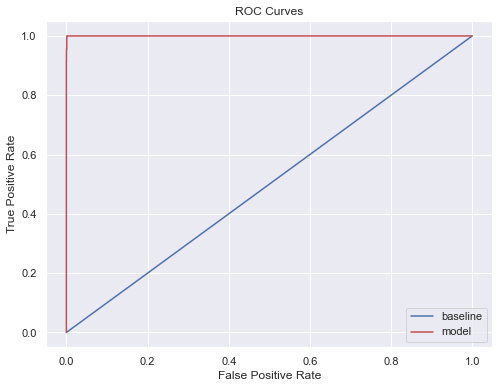

In [27]:
evaluate_model(predictions, probs, train_predictions, train_probs)

There we can see the problem with a single decision tree where the maximum depth is not limited: __severe overfitting to the training data__. 

Another method to inspect the performance of a classification model is by making a confusion matrix.

In [29]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[10489     0]
 [    5    18]]


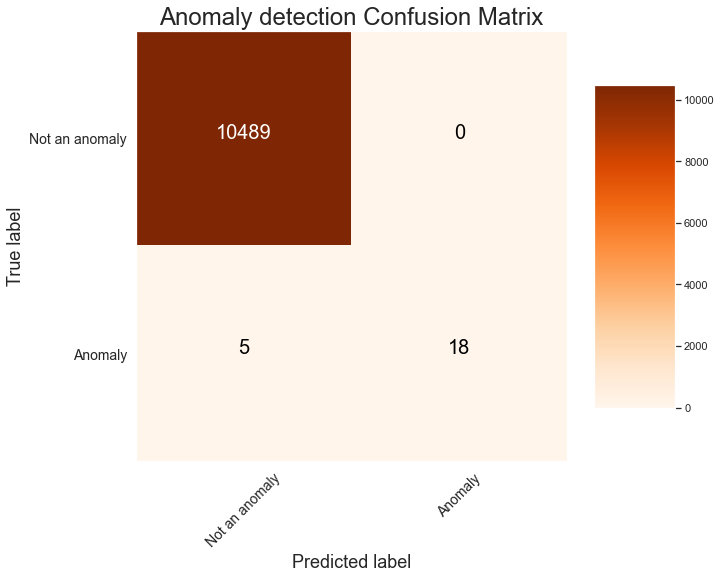

In [32]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, classes = ['Not an anomaly', 'Anomaly'],
                      title = 'Anomaly detection Confusion Matrix')

This shows the classifications predicted by the model on the test data along with the real labels. We can see that our model has many false negatives (predicted good health but actually poor health) and false positives (predicted poor health but actually good health). 

### Feature Importances

Finally, we can take a look at the features considered most important by the Decision Tree. The values are computed by summing the reduction in Gini Impurity over all of the nodes of the tree in which the feature is used. 

In [35]:
df1=df.drop(columns=['anomaly'])
df1

,date,time,flow,dayofweek
0,736695,0,18.333067,-1
1,736695,1,18.333067,-1
2,736695,2,19.784872,-1
3,736695,3,22.294744,-1
4,736695,4,27.229756,-1
...,...,...,...,...
35035,737059,91,24.792000,0
35036,737059,92,23.029933,0
35037,737059,93,20.415628,0
35038,737059,94,22.019056,0


In [36]:
fi = pd.DataFrame({'feature': df1,
                   'importance': classifier.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

,feature,importance
0,"(d, a, t, e)",0.437635
1,"(t, i, m, e)",0.279614
2,"(f, l, o, w)",0.212933
3,"(d, a, y, o, f, w, e, e, k)",0.069818


We won't go through the definitions here, but you can look through the [data dictionary](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system#2015_formats.json) to determine the meaning of each feature. 

In [41]:
from sklearn.tree import export_graphviz
# Save tree as dot file
export_graphviz(classifier, 'tree_real_data.dot', rounded = True, 
                feature_names = df, max_depth = 4,
                class_names = ['Not an anomaly', 'Anomaly'], filled = True)

# Convert to png
call(['dot', '-Tpng', 'tree_real_data.dot', '-o', 'tree_real_data.png', '-Gdpi=200'])

# Visualize
Image(filename='tree_real_data.png')

ValueError: Length of feature_names, 35040 does not match number of features, 4

# Random Forest 

Now we can move on to a more powerful model, the random forest. This takes the idea of a single decision tree, and creates an _ensemble_ model out of hundreds or thousands of trees to reduce the variance. Each tree is trained on a random set of the observations, and for each split of a node, only a subset of the features are used for making a split. When making predictions, the random forest averages the predictions for each of the individual decision trees for each data point in order to arrive at a final classification.

In [43]:
from sklearn.ensemble import RandomForestClassifier

# Set random seed to ensure reproducible runs
RSEED = 50

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


RandomForestClassifier(max_features='sqrt', n_jobs=-1, random_state=50,
                       verbose=1)

We can see how many nodes there are for each tree on average and the maximum depth of each tree. There were 100 trees in the forest.

In [44]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 64
Average maximum depth 9


We see that each decision tree in the forest has many nodes and is extremely deep. However, even though each individual decision tree may overfit to a particular subset of the training data, the idea is that the overall random forest should have a reduced variance. 

In [45]:
train_rf_predictions = model.predict(X_train)
train_rf_probs = model.predict_proba(X_train)[:, 1]

rf_predictions = model.predict(X_test)
rf_probs = model.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Recall Baseline: 1.0 Test: 0.87 Train: 1.0
Precision Baseline: 0.0 Test: 1.0 Train: 1.0
Roc Baseline: 0.5 Test: 1.0 Train: 1.0


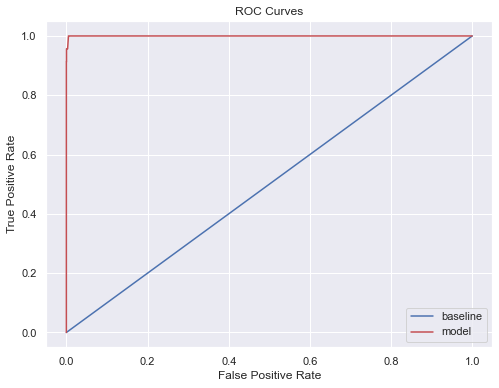

In [46]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

The model still achieves perfect measures on the training data, but this time, the testing scores are much better. If we compare the ROC AUC, we see that the random forest does significantly better than a single decision tree. 

Confusion matrix, without normalization
[[10489     0]
 [    3    20]]


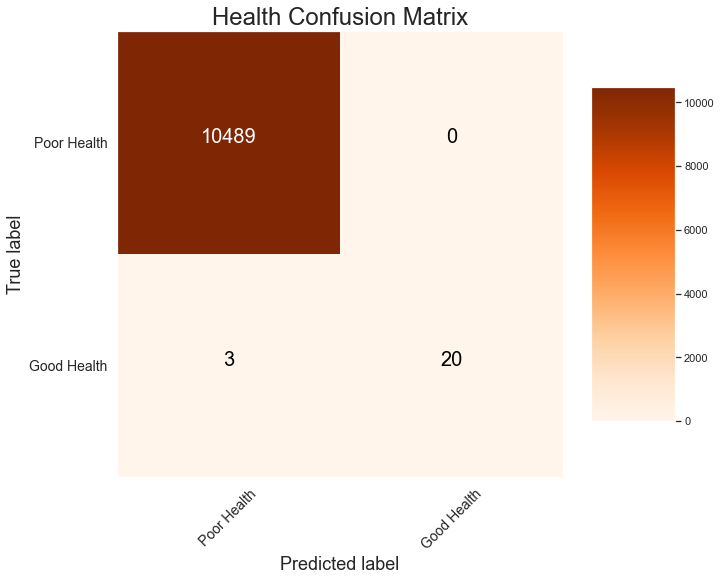

In [48]:
cm = confusion_matrix(y_test, rf_predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

In [49]:
fi_model = pd.DataFrame({'feature': df1,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

,feature,importance
0,"(d, a, t, e)",0.435422
1,"(t, i, m, e)",0.276125
2,"(f, l, o, w)",0.222620
3,"(d, a, y, o, f, w, e, e, k)",0.065834


# Random Forest Optimization through Random Search

In order to maximize the performance of the random forest, we can perform a random search for better hyperparameters. This will randomly select combinations of hyperparameters from a grid, evaluate them using cross validation on the training data, and return the values that perform the best. 

In [50]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=RSEED)

# Fit 
rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.5s finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=50),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                     

In [51]:
rs.best_params_

{'n_estimators': 188,
 'min_samples_split': 2,
 'max_leaf_nodes': 33,
 'max_features': 0.7999999999999999,
 'max_depth': 12,
 'bootstrap': True}

We can see that the best hyperparameter values are not the defaults. This shows the importance of tuning a model for a specific dataset. Each dataset will have different characteristics, and the model that does best on one dataset will not necessarily do the best across all datasets. 

### Use Best Model

Now we can take the best model (it has already been trained) and evaluate it. Hopefully it does better than the stock Random Forest.

In [52]:
best_model = rs.best_estimator_

In [53]:
train_rf_predictions = best_model.predict(X_train)
train_rf_probs = best_model.predict_proba(X_train)[:, 1]

rf_predictions = best_model.predict(X_test)
rf_probs = best_model.predict_proba(X_test)[:, 1]

In [54]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 54
Average maximum depth 8


The best maximum depth is not unlimited as we see above! This indicates that restricting the maximum depth of the individual decision trees can improve the cross validation performance of the random forest. 

Recall Baseline: 1.0 Test: 0.7 Train: 1.0
Precision Baseline: 0.0 Test: 1.0 Train: 1.0
Roc Baseline: 0.5 Test: 1.0 Train: 1.0


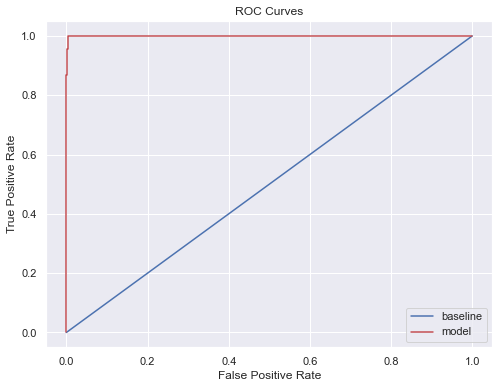

In [55]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

The optimized model achieves around the same performance as the default model. More random search iterations could improve performance, or it's possible that we are close the limit of what the random forest can achieve for this problem.

In [58]:
estimator = best_model.estimators_[1]

# Export a tree from the forest
export_graphviz(estimator, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names=X_train, max_depth = 8, 
                class_names = ['poverty', 'no poverty'], filled = True)

ValueError: Length of feature_names, 24528 does not match number of features, 4

In [60]:
from subprocess import call
# Convert to png
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=400']);

call(['dot', '-Tpng', 'tree_from_optimized_forest.dot', '-o', 'tree_from_optimized_forest.png', '-Gdpi=200'])
Image('tree_from_optimized_forest.png')

FileNotFoundError: [WinError 2] The system cannot find the file specified